## Headers

In [28]:
model_ckpt = 'xlm-roberta-base'

## Load the dataset

In [29]:
from datasets import load_dataset

dataset = load_dataset("csv", data_files={"train": ["Data/banking_train.csv",
                                        "Data/user_train.csv"],
                                         "test": ["Data/banking_test.csv",
                                         "Data/user_test.csv"]})

dataset

Using custom data configuration default-2c3fc2c86faf0cf3


Extracting data files: 100%|██████████| 2/2 [00:00<00:00, 1903.04it/s]
0 tables [00:00, ? tables/s]/home/sameh/sourcecode/nlpmvp_train/venv/lib/python3.10/site-packages/datasets/download/streaming_download_manager.py:697: FutureWarning: the 'mangle_dupe_cols' keyword is deprecated and will be removed in a future version. Please take steps to stop the use of 'mangle_dupe_cols'
  return pd.read_csv(xopen(filepath_or_buffer, "rb", use_auth_token=use_auth_token), **kwargs)
/home/sameh/sourcecode/nlpmvp_train/venv/lib/python3.10/site-packages/datasets/download/streaming_download_manager.py:697: FutureWarning: the 'mangle_dupe_cols' keyword is deprecated and will be removed in a future version. Please take steps to stop the use of 'mangle_dupe_cols'
  return pd.read_csv(xopen(filepath_or_buffer, "rb", use_auth_token=use_auth_token), **kwargs)
0 tables [00:00, ? tables/s]/home/sameh/sourcecode/nlpmvp_train/venv/lib/python3.10/site-packages/datasets/download/streaming_download_manager.py:697: 

Dataset csv downloaded and prepared to /home/sameh/.cache/huggingface/datasets/csv/default-2c3fc2c86faf0cf3/0.0.0/652c3096f041ee27b04d2232d41f10547a8fecda3e284a79a0ec4053c916ef7a. Subsequent calls will reuse this data.


100%|██████████| 2/2 [00:00<00:00, 1375.18it/s]


DatasetDict({
    train: Dataset({
        features: ['Unnamed: 0', 'text', 'label'],
        num_rows: 10010
    })
    test: Dataset({
        features: ['Unnamed: 0', 'text', 'label'],
        num_rows: 3084
    })
})

## Get Labels

In [30]:
import pandas as pd

labels_df = pd.read_csv("Data/intents.csv")
labels_df.set_index(['label'])
labels_df

,label,intent
0,0,activate_my_card
1,1,age_limit
2,2,apple_pay_or_google_pay
3,3,atm_support
4,4,automatic_top_up
...,...,...
74,74,why_verify_identity
75,75,wrong_amount_of_cash_received
76,76,wrong_exchange_rate_for_cash_withdrawal
77,80,balance_check


In [31]:
def getIntent(label):
    return labels_df.loc[labels_df['label'] == label]

## Tokenize the whole dataset

In [32]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

In [33]:
def tokenize(batch):
    return tokenizer(batch["text"], padding=True, truncation=True)

In [34]:
dataset_encoded = dataset.map(tokenize, batched=True, batch_size=None)

100%|██████████| 1/1 [00:00<00:00, 12.27ba/s]


In [35]:
# applying the extract_hidden_states() function has added a new hidden_state
# column to our dataset:
print(dataset_encoded["train"].column_names)

['Unnamed: 0', 'text', 'label', 'input_ids', 'attention_mask']


## Training a Text Classifier
In the feature-based approach, the DistilBERT model is frozen and just provides features for a classifier

In [36]:
from transformers import AutoModel
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Load the model
model = AutoModel.from_pretrained(model_ckpt)
model = model.to(device)

Some weights of the model checkpoint at xlm-roberta-base were not used when initializing XLMRobertaModel: ['lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing XLMRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [37]:
#  we’ll use the map() method of DatasetDict to extract all the hidden states in one go

def extract_hidden_states(batch):
  # Place model inputs on the GPU
  inputs = {k:v.to(device) for k,v in batch.items()
            if k in tokenizer.model_input_names}
  # Extract last hidden states
  with torch.no_grad():
    last_hidden_state = model(**inputs).last_hidden_state
  # Return vector for [CLS] token
  return {"hidden_state": last_hidden_state[:,0].cpu().numpy()}

In [38]:
#  convert the input_ids and attention_mask columns to the "torch" format

dataset_encoded.set_format("torch", columns=["input_ids", 
                                              "attention_mask", "label"])

In [39]:
dataset_encoded

DatasetDict({
    train: Dataset({
        features: ['Unnamed: 0', 'text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 10010
    })
    test: Dataset({
        features: ['Unnamed: 0', 'text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 3084
    })
})

In [40]:
dataset_hidden = dataset_encoded.map(extract_hidden_states, batched=True)

100%|██████████| 4/4 [05:18<00:00, 79.58s/ba] 


In [41]:
# applying the extract_hidden_states() function has added a new hidden_state
# column to our dataset:
dataset_hidden["train"].column_names

['Unnamed: 0', 'text', 'label', 'input_ids', 'attention_mask', 'hidden_state']

### Creating a feature matrix

The preprocessed dataset now contains all the information we need to train
a classifier on it. We will use the hidden states as input features and the
labels as targets. We can easily create the corresponding arrays in the wellknown Scikit-learn format as follows:

In [42]:
import numpy as np

labels = labels_df["intent"]

X_train = np.array(dataset_hidden["train"]["hidden_state"])
X_valid = np.array(dataset_hidden["test"]["hidden_state"])
y_train = np.array(dataset_hidden["train"]["label"])
y_valid = np.array(dataset_hidden["test"]["label"])
X_train.shape, X_valid.shape

((10010, 768), (3084, 768))

## Training a simple classifier

Confusion matrix of the classifier

In [43]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import matplotlib.pyplot as plt

def plot_confusion_matrix(y_preds, y_true, labels):
  cm = confusion_matrix(y_true, y_preds, normalize="true")
  fig, ax = plt.subplots(figsize=(50, 50))
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
  disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False, xticks_rotation=90)
  plt.title("Normalized confusion matrix")
  plt.show()

SVM classifier

In [44]:
# SVM
from sklearn.svm import LinearSVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.calibration import CalibratedClassifierCV

svm = make_pipeline(StandardScaler(),
                     LinearSVC(random_state=0, tol=1e-5))

clf_svm = CalibratedClassifierCV(svm)
clf_svm.fit(X_train, y_train)
clf_svm.score(X_valid, y_valid)
# y_proba = clf_svm.predict_proba(X_valid)

/home/sameh/sourcecode/nlpmvp_train/venv/lib/python3.10/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/sameh/sourcecode/nlpmvp_train/venv/lib/python3.10/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/sameh/sourcecode/nlpmvp_train/venv/lib/python3.10/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/sameh/sourcecode/nlpmvp_train/venv/lib/python3.10/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/sameh/sourcecode/nlpmvp_train/venv/lib/python3.10/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


0.8884565499351491

Logistic regression

In [45]:
# Logistic regression

from sklearn.linear_model import LogisticRegression

# We increase `max_iter` to guarantee convergence
clf_lr = LogisticRegression(max_iter=3000)
clf_lr.fit(X_train, y_train)
clf_lr.score(X_valid, y_valid)

0.7551880674448768

F1-score

In [46]:
# f1 score
from sklearn.metrics import f1_score, accuracy_score

labels = labels_df["intent"]
y_preds = clf_svm.predict(X_valid)

f1 = f1_score(y_valid, y_preds, average="weighted")
# acc = accuracy_score(labels, y_preds)

print(f1)

0.8885897722392283


Cross validation

In [47]:
# cross validation
from sklearn.model_selection import cross_val_predict

y_preds = cross_val_predict(clf_svm, X_train, y_train, cv=3)

/home/sameh/sourcecode/nlpmvp_train/venv/lib/python3.10/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/sameh/sourcecode/nlpmvp_train/venv/lib/python3.10/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/sameh/sourcecode/nlpmvp_train/venv/lib/python3.10/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/sameh/sourcecode/nlpmvp_train/venv/lib/python3.10/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/sameh/sourcecode/nlpmvp_train/venv/lib/python3.10/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home

In [48]:
y_preds.shape

(10010,)

ValueError: The number of FixedLocator locations (78), usually from a call to set_ticks, does not match the number of ticklabels (79).

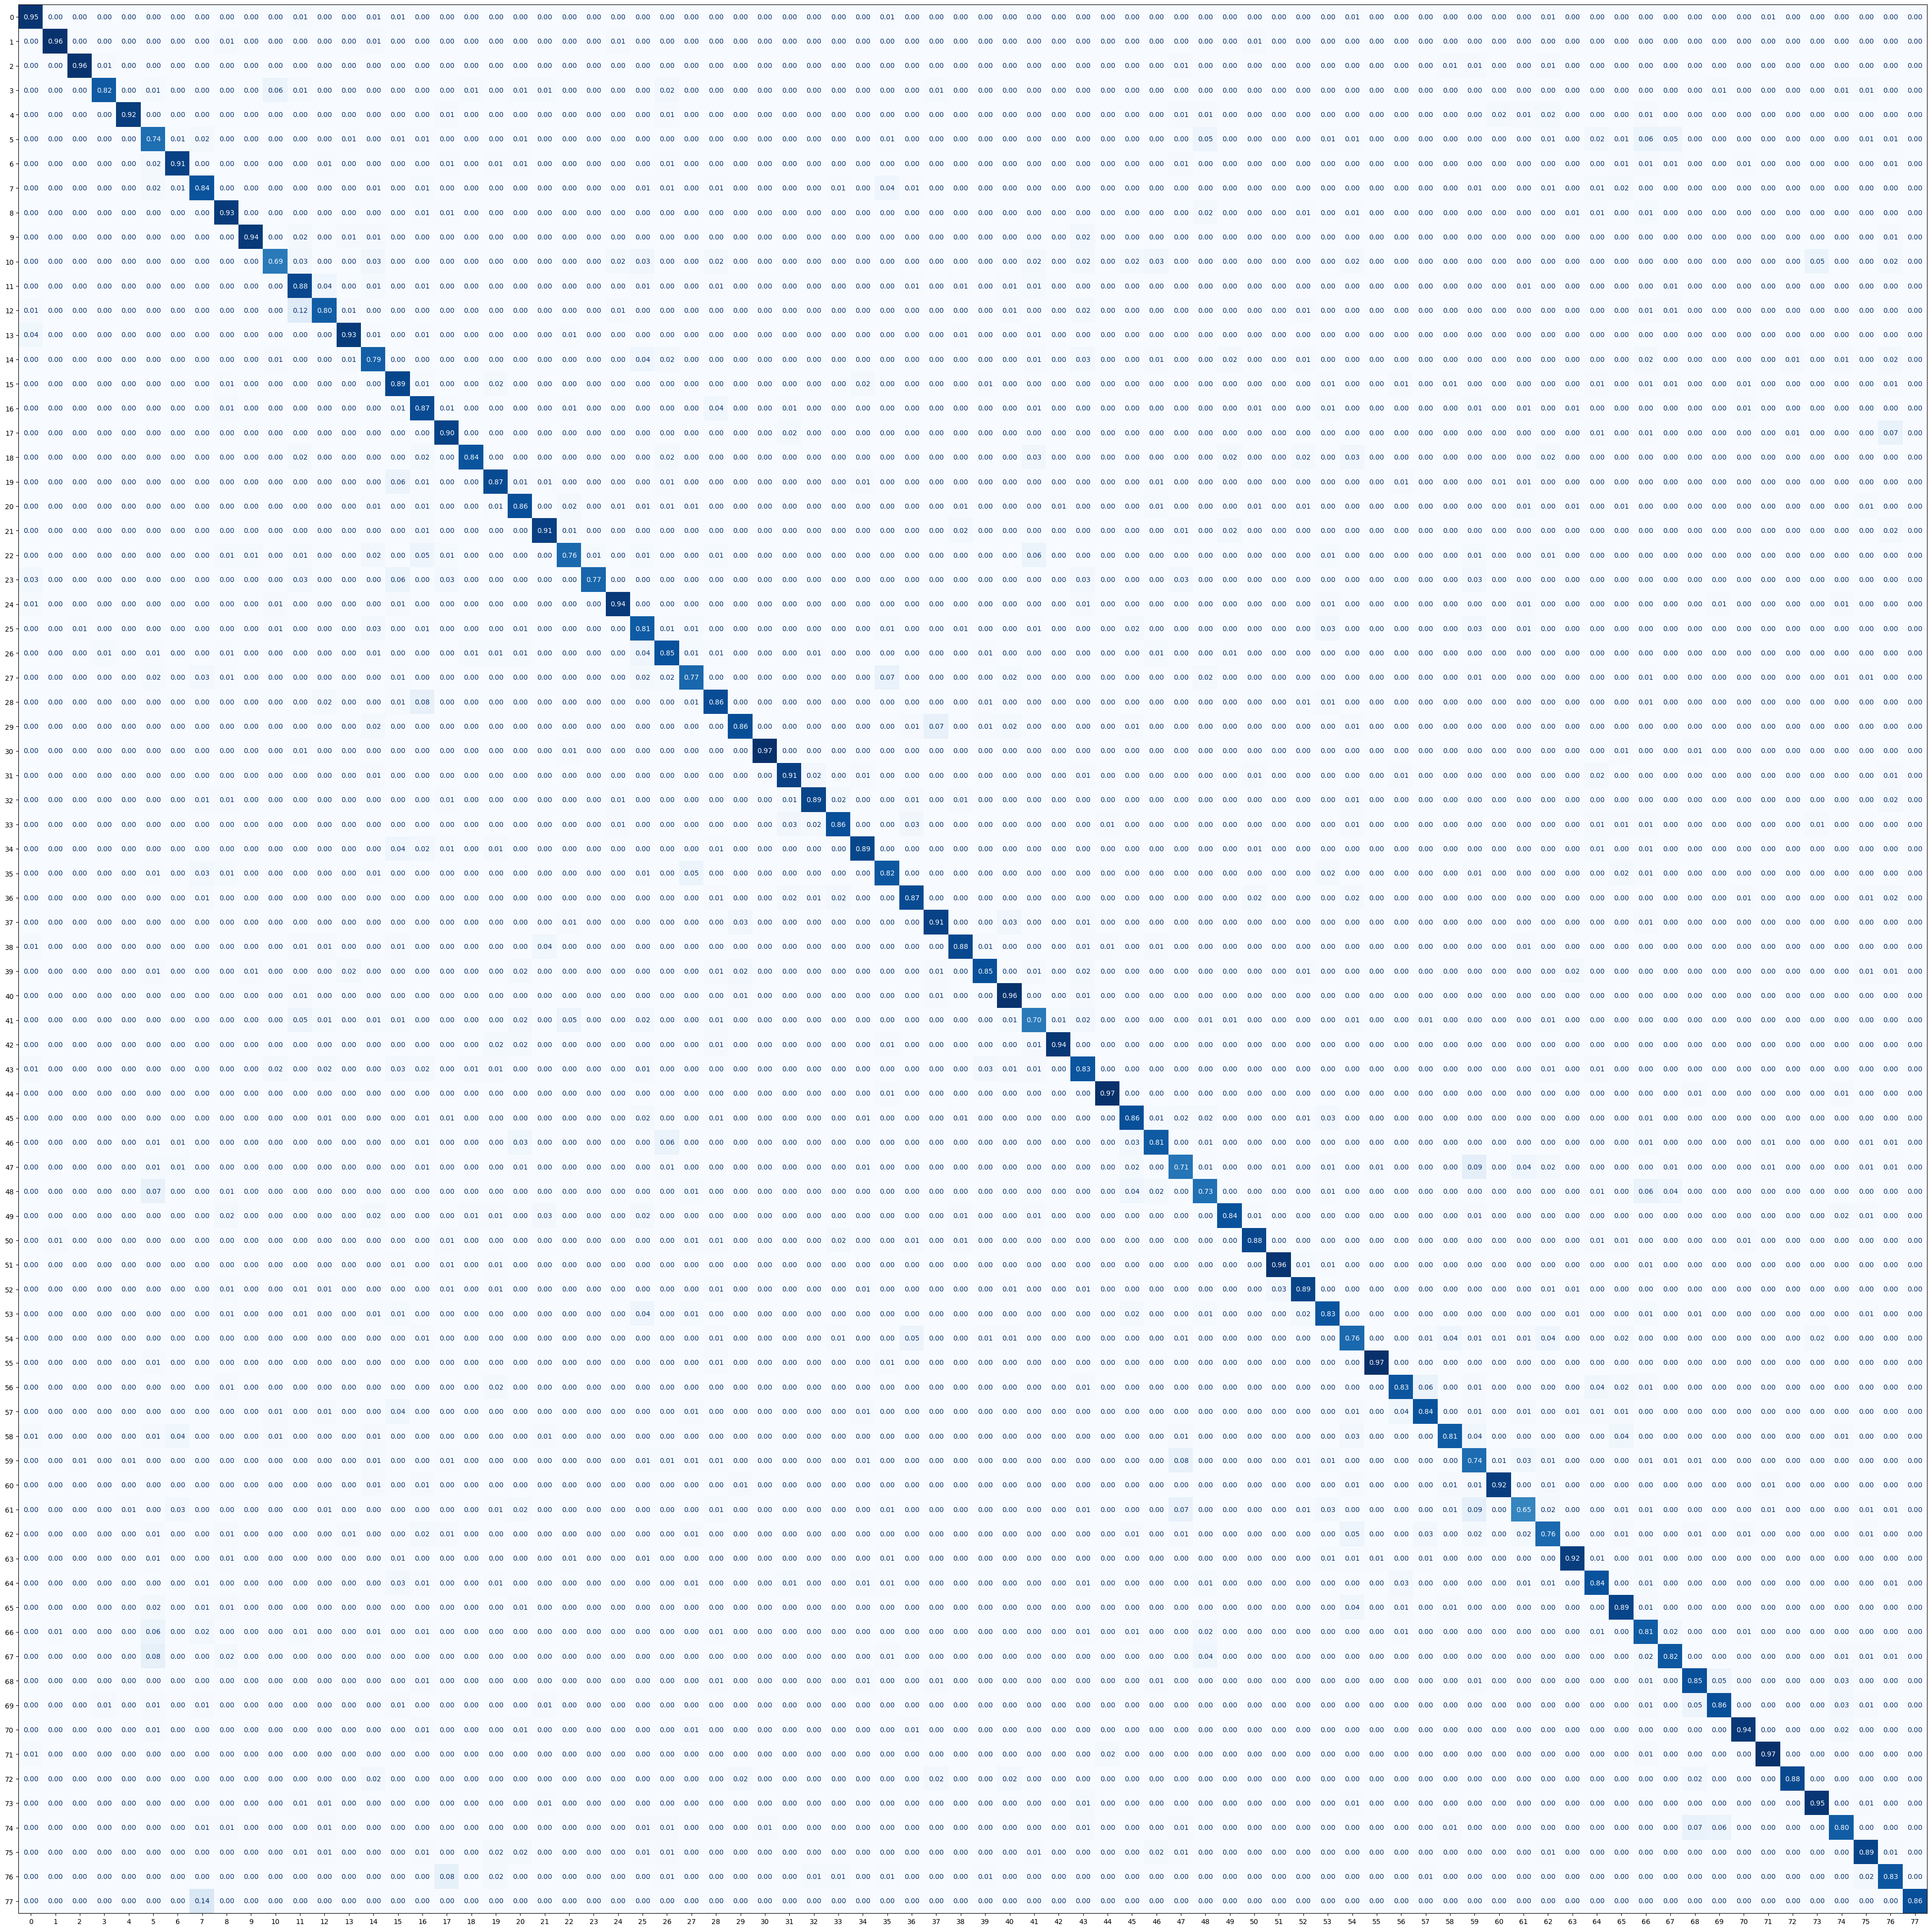

In [49]:

plot_confusion_matrix(y_preds, y_train, labels)

## Model prediction

In [ ]:
def model_predict(pred_text):
  pred_inputs = tokenizer(pred_text, return_tensors="pt")
  # print(pred_inputs)

  pred_inputs = {k:v.to(device) for k,v in pred_inputs.items()}
  with torch.no_grad():
    pred_hidden_state = model(**pred_inputs).last_hidden_state[:,0].cpu().numpy()

  return clf_svm.predict(pred_hidden_state), clf_svm.predict_proba(pred_hidden_state)

In [ ]:
predtext = "When did you send me my new card"
pred = model_predict(predtext)
print(np.max(pred[1]))
print(getIntent(pred[0][0]))

## Save the model on disk

In [ ]:
import pickle
filename = 'models/banking_classifier.sav'
pickle.dump(clf_svm, open(filename, 'wb'))